# CS 579
<br>

## Clustering Words with K-Means

<br>


In [1]:
import pandas as pd
movies = pd.DataFrame([[123, ['horror', 'horror', 'romance', 'romance', 'romance']], [456, ['romance']]], columns=['movieId', 'tokens'])
movies

,movieId,tokens
0,123,"[horror, horror, romance, romance, romance]"
1,456,[romance]


tfidf(i, d) := tf(i, d) / max_k tf(k, d) * log10(N/df(i))

- df(horror) = 1
- df(romance) = 2

- tf (horror, 123) = 2
- tfidf(horror, 123) = 2 / 3 * log10(2/1)

In [2]:
d = {'a': 100, 'b': 200}
for x,y in enumerate(d):
    print(x, y)


0 b
1 a


In [3]:
for x in ['a', 'b', 'c']:
    print(x)

a
b
c


In [4]:
import networkx as nx
nx.__version__
import networkx.algorithms.community as ccc
dir(ccc)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'k_clique_communities',
 'kclique']

In [5]:
from scipy.sparse import csr_matrix

a = csr_matrix([1,2,3, 0, 0, 0, 5])
b = csr_matrix([4,5,6, 0, 0, 0, 0])
a.dot(b.T).sum()


32

In [6]:
from collections import Counter
import math

def featurize(movies):
    dfs = Counter()
    data = []
    rows = []
    cols = []
    for tokens in movies['tokens']:
        dfs.update(set(tokens))
    vocab = {v: i for i, v in enumerate(sorted(dfs))}
    N = len(movies)
    n_cols = len(vocab)
    vectors = []
    for tokens in movies.tokens:
        tfs = Counter(tokens)
        maxtf = max(tfs.values())
        rows = [0] * len(tfs)
        cols = [vocab[t] for t in tfs]
        data = [v / maxtf * math.log10(N / dfs[t])
                for t, v in tfs.items()]
        print('tf:', [v / maxtf for t, v in tfs.items()])
        print('idf_weight:', [math.log10(N / dfs[t]) for t, v in tfs.items()])

        vectors.append(csr_matrix((data, (rows, cols)), shape=(1, n_cols)))
        
    movies['features'] = vectors
    return movies, vocab

movies, vocab = featurize(movies)
movies

tf: [1.0, 0.6666666666666666]
idf_weight: [0.0, 0.3010299956639812]
tf: [1.0]
idf_weight: [0.0]


,movieId,tokens,features
0,123,"[horror, horror, romance, romance, romance]","(0, 0)\t0.200686663776\n (0, 1)\t0.0"
1,456,[romance],"(0, 1)\t0.0"


In [7]:
movies['features'][0].todense()

matrix([[ 0.20068666,  0.        ]])

# Motivation

Often, we want to know which features appear together.

- If you liked *Twilight* you might like *Nosferatu*.
- "happy" is a synonym of "glad."

Can be used to summarize a large collection of messages.

We'll use k-means to cluster together related words from Twitter.

**Caution:** This uses live Twitter data, which often contains profanity.

In [8]:
# Get some tweets containing the word 'i'.

import os
from TwitterAPI import TwitterAPI

# Read Twitter credentials from environmental variables.
#api = TwitterAPI(os.environ.get('TW_CONSUMER_KEY'),
#                 os.environ.get('TW_CONSUMER_SECRET'),
#                 os.environ.get('TW_ACCESS_TOKEN'),
#                 os.environ.get('TW_ACCESS_TOKEN_SECRET'))
#my info
consumer_key = 'Q6sCDic9j8mNMhZB2BysN69vr'
consumer_secret = 'FdaQjrFThC0F3xddTZ1WnwhNmCtw08es0X1EIMCloQmOfxUc47'
access_token = '3584891536-Lm7t8eHMyf9l0MDXVdXwL4gj2xKZJ6EHzxp85ev'
access_token_secret = 'cajDlqGO2ExbHh0cRLK4WOyzw1i5E7Q4EIIi4qe99EoG2'
api = TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)

# Collect 10000 tweets.
tweets = []
while True: 
    r = api.request('statuses/filter', {'track':'i',
                                      'language':'en'})
    if r.status_code != 200: # error
        break
    else:
        for item in r.get_iterator():
            tweets.append(item)
            if len(tweets) > 10000:
                break
            elif len(tweets) % 100 == 0:
                print(len(tweets))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [9]:
print(len(tweets))

10002


In [49]:
# Each tweet is a Python dict.
print('text:', tweets[1]['text'])
print('description:', tweets[1]['user']['description'])
print('name:', tweets[1]['user']['name'])
print('location:', tweets[1]['user']['location'])

text: hahahaha I knew you would know and thats why you sir are the fuckin MAN!!!! https://t.co/j95uXUSDNb
description: Three friends Ray, Danielle @DarkErraticRed
& Chris @hifunctioning tackle topics with IRREVERENT HUMOR, RIDICULOUSNESS & have a good time!! @FYFCStudios
name: TheNakedPorchPodcast
location: New York, USA


In [50]:
tweets = [t for t in tweets if 'text' in t]

In [51]:
len(tweets)

9234

In [52]:
# Tokenize each tweet text.
import re
tokens = []
for tweet in tweets:
    text = tweet['text'].lower()
    text = re.sub('@\S+', ' ', text)  # Remove mentions.
    text = re.sub('http\S+', ' ', text)  # Remove urls.
    tokens.append(re.findall('[A-Za-z]+', text)) # Retain words.
print(len(tokens))
tokens[1]

9234


['hahahaha',
 'i',
 'knew',
 'you',
 'would',
 'know',
 'and',
 'thats',
 'why',
 'you',
 'sir',
 'are',
 'the',
 'fuckin',
 'man']

In [53]:
# Count words.
from collections import Counter

word_counts = Counter()
for tweet in tokens:
    word_counts.update(tweet)

In [54]:
# Inspect word counts.
import math

print(len(word_counts), 'unique terms')
word_counts.most_common(10)

10511 unique terms


[('i', 11056),
 ('rt', 4315),
 ('to', 2821),
 ('the', 2610),
 ('you', 2262),
 ('a', 2253),
 ('m', 2026),
 ('my', 1742),
 ('and', 1738),
 ('t', 1510)]

In [55]:
# Retain in vocabulary words occurring more than twice.
vocab = set([w for w, c in word_counts.items() if c > 2])
print('%d words occur at least three times.' % len(vocab))

3232 words occur at least three times.


In [56]:
# Prune tokens.
newtoks = []
for i, tweet in enumerate(tokens):
    newtok = [token for token in tweet if token in vocab]
    if len(newtok) > 0:
        newtoks.append(newtok)
tokens = newtoks
print(len(tokens))

9217


In [57]:
# A sample pruned tweet.
tokens[1]

['hahahaha',
 'i',
 'knew',
 'you',
 'would',
 'know',
 'and',
 'thats',
 'why',
 'you',
 'sir',
 'are',
 'the',
 'fuckin',
 'man']

In [58]:
import numpy as np
# find the tokens occurs to the 'window' left or 'window' right of term i in a tweet
def get_contexts(tweet, i, window):
    features = []
    for j in range(np.amax([0, i-window]), i):
        features.append(tweet[j] + "@" + str(j-i))
    for j in range(i+1, min(i + window + 1, len(tweet))):
        features.append(tweet[j] + "@" + str(j-i))
    return features

get_contexts(tokens[1], i=3, window=2)

['i@-2', 'knew@-1', 'would@1', 'know@2']

In [59]:
# For each term (of all tweets after we pruned, recorded as in vocab), create a context vector, indicating how often
# each word occurs to the left or right of it.
from collections import defaultdict
import numpy as np

# dict from term to context vector.
contexts = defaultdict(lambda: Counter())
window = 2
#sum=0
for tweet in tokens:
    for i, token in enumerate(tweet):
        features = get_contexts(tweet, i, window)
        #sum+=len(features)
        contexts[token].update(features)
        # Optionally: ignore word order
        # contexts[token].update(tweet[:i] + tweet[i+1:])
#sum

True


In [73]:
print(len(contexts), len(vocab))

3232 3232


In [60]:
print(len(contexts['i']))
#contexts['i']

4068


Counter({'bf@-1': 1,
         'receive@2': 2,
         'them@2': 29,
         'beast@-2': 1,
         'red@-1': 2,
         'badthingsonfallon@1': 1,
         'pushing@2': 2,
         'blessed@2': 4,
         'play@2': 2,
         'because@2': 6,
         'man@2': 2,
         'self@-1': 3,
         'someone@-1': 7,
         'now@-1': 71,
         'due@-1': 1,
         'fake@2': 5,
         'officially@2': 2,
         'finding@-1': 1,
         'met@2': 1,
         'pockets@-2': 1,
         'repeat@1': 5,
         'read@-1': 1,
         'box@-2': 3,
         'walking@2': 1,
         'hang@2': 1,
         'after@1': 1,
         'photoshoot@-2': 1,
         'although@-1': 4,
         'agree@-2': 1,
         'hip@2': 1,
         'bought@2': 2,
         't@1': 2,
         'seconds@2': 1,
         'above@-2': 1,
         'snow@-1': 1,
         'minutes@-2': 1,
         'wasn@1': 18,
         'burn@1': 1,
         'lmao@-1': 11,
         'drinking@-2': 2,
         'guess@2': 1,
         'under

In [61]:
contexts['i'].most_common(20)

[('m@1', 1996),
 ('rt@-1', 1796),
 ('t@2', 788),
 ('a@2', 553),
 ('rt@-2', 513),
 ('love@1', 436),
 ('to@2', 429),
 ('you@2', 408),
 ('can@1', 402),
 ('just@1', 401),
 ('don@1', 377),
 ('and@-1', 348),
 ('when@-1', 299),
 ('ll@1', 280),
 ('ve@1', 279),
 ('want@1', 262),
 ('have@1', 261),
 ('but@-1', 259),
 ('need@1', 252),
 ('am@1', 247)]

In [62]:
# Compute the number of different contexts each term appears in.
tweet_freq = Counter()
for context in contexts.values():
    tweet_freq.update(context)
print(len(tweet_freq))
tweet_freq.most_common(5)

12769


[('i@-1', 11009),
 ('i@-2', 10603),
 ('i@1', 8596),
 ('i@2', 6257),
 ('rt@-1', 4309)]

In [63]:
# Transform each context vector to be term freq / tweet frequency. 
# Also then normalize by length.
for term, context in contexts.items():
    for term2, frequency in context.items():
        context[term2] = frequency / (1. + math.log(tweet_freq[term2]))
    length = math.sqrt(sum([v*v for v in context.values()]))
    for term2, frequency in context.items():
        context[term2] = 1. * frequency / length

#print(contexts['i'])
contexts['i'].most_common(5)

Counter({'m@1': 0.5675395289138095, 'rt@-1': 0.4695096085441682, 't@2': 0.23269359358975453, 'a@2': 0.1558877082886095, 'love@1': 0.14195615060916741, 'rt@-2': 0.13416820634874826, 'can@1': 0.13098891268646748, 'just@1': 0.1274506691895401, 'don@1': 0.12374380641502394, 'to@2': 0.11768125851129094, 'you@2': 0.11564383404742684, 'and@-1': 0.10097304577407498, 'll@1': 0.10081386326998105, 've@1': 0.09963624856788521, 'when@-1': 0.0996180254531292, 'need@1': 0.09010713734356285, 'want@1': 0.08944566137853868, 'am@1': 0.08897180585755213, 'have@1': 0.08599759116539336, 'but@-1': 0.08405124962860898, 'was@1': 0.08205964640111221, 'think@1': 0.07262098193556733, 'not@2': 0.0695330563181121, 'so@2': 0.06838424429130213, 'it@2': 0.06521535207689458, 'will@1': 0.06495232881148837, 'the@2': 0.06395006843496577, 'if@-1': 0.0632717667994391, 'me@-2': 0.060710143495108886, 'know@1': 0.05927062673608365, 'liked@1': 0.05557938545449624, 'got@1': 0.05477999854703162, 'the@-2': 0.05416465488882134, 'i@

[('m@1', 0.5675395289138095),
 ('rt@-1', 0.4695096085441682),
 ('t@2', 0.23269359358975453),
 ('a@2', 0.1558877082886095),
 ('love@1', 0.14195615060916741)]

In [64]:
contexts['school'].most_common(10)

[('ck@-1', 0.4136540315361625),
 ('high@-1', 0.3942296402243195),
 ('middle@-1', 0.36333907866459314),
 ('f@-2', 0.28159260016022825),
 ('to@-1', 0.21782389745590142),
 ('i@1', 0.171690848777721),
 ('old@-1', 0.16688422512193513),
 ('don@2', 0.1483382433264341),
 ('go@-2', 0.1344016074316236),
 ('was@2', 0.12169461102366234)]

At this point we have a list of dictionaries, one per term, indicating the terms that co-occur (weighted by inverse tweet frequency).

Next, we have to cluster these vectors. To do this, we'll need to be able to compute the euclidean distance between two vectors.

In [65]:
# This is not efficient!
def distance(c1, c2):
    if len(c1.keys()) == 0 or len(c2.keys()) == 0:
        return 1e9
    keys = set(c1.keys()) | set(c2.keys())
    distance = 0.
    #print('context\tc1\tc2\td')
    for k in keys:
        #print(k, '\t%d\t%d\t%d'%(c1[k],c2[k], (c1[k] - c2[k]) ** 2))
        distance += (c1[k] - c2[k]) ** 2
    return math.sqrt(distance)

print(distance({'hi':10, 'bye': 5}, {'hi': 9, 'bye': 4}))
print(distance({'hi':10, 'bye': 5}, {'hi': 8, 'bye': 4}))

1.4142135623730951
2.23606797749979


In [66]:
print(distance(contexts['i'], contexts['love']))

1.3549170569890574


In [71]:
def find_closest(term, n=5):
    terms = np.array(list(contexts.keys()))
    context = contexts[term]
    distances = []
    for term2, context2 in contexts.items():
        distances.append(distance(context, context2))
    return terms[np.argsort(distances)][:n], np.argsort(distances)[:n]

find_closest('love', n=10)

(array(['love', 'm', 'hope', 'hate', 'am', 'got', 'miss', 'll', 'need',
        'think'], 
       dtype='<U25'),
 array([2376,  782, 2704, 2684,  974, 1613, 1266, 2904,  746, 1239]))

In [72]:
nz_contexts = [t for t, context in contexts.items()
               if len(context) > 1]
contexts = dict([(term, contexts[term]) for term in nz_contexts])
print(len(nz_contexts), 'nonzero contexts')

3232 nonzero contexts


In [75]:
list(contexts.keys())[0]

'however'

In [76]:
list(contexts.values())[0]

Counter({'above@1': 0.3367533792480383,
         'all@2': 0.11695862125583531,
         'disagree@-1': 0.3682433522315904,
         'emily@1': 0.3682433522315904,
         'great@-2': 0.17679787228475324,
         'i@-2': 0.08557271931510677,
         'i@1': 0.08735783575157623,
         'me@-1': 0.21612631944458896,
         'person@-1': 0.16567237006122174,
         'quality@-2': 0.3147610116974397,
         'treat@-2': 0.48294761821904847,
         've@2': 0.13441825047610623,
         'want@2': 0.24847490517374307,
         'year@-1': 0.16835630572567212,
         'you@1': 0.2021811893438085})

In [77]:
# Transform context dicts to a sparse vector
# for sklearn.
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
X = vec.fit_transform(contexts.values())
names = np.array(vec.get_feature_names())
print(names[:10])
print(X[0])

['a@-1' 'a@-2' 'a@1' 'a@2' 'ab@-1' 'ab@-2' 'ab@1' 'ab@2' 'abandon@-1'
 'abandon@-2']
  (0, 34)	0.336753379248
  (0, 278)	0.116958621256
  (0, 2947)	0.368243352232
  (0, 3467)	0.368243352232
  (0, 4748)	0.176797872285
  (0, 5530)	0.0855727193151
  (0, 5531)	0.0873578357516
  (0, 6957)	0.216126319445
  (0, 8191)	0.165672370061
  (0, 8819)	0.314761011697
  (0, 11497)	0.482947618219
  (0, 11910)	0.134418250476
  (0, 12075)	0.248474905174
  (0, 12649)	0.168356305726
  (0, 12699)	0.202181189344


In [81]:
# Which row of X is the word "love"?
love_idx = list(contexts.keys()).index('love')
print(love_idx)
# What are the context feature values for love?
print(X[love_idx])
# Print a highly ranking feature.
print(names[12768])

2352
  (0, 0)	0.00233544487742
  (0, 2)	0.00465236940575
  (0, 3)	0.0116648480196
  (0, 28)	0.0118672025612
  (0, 30)	0.00294107366618
  (0, 31)	0.00589164628616
  (0, 36)	0.0116323536582
  (0, 71)	0.00495444218415
  (0, 108)	0.00384121959793
  (0, 141)	0.00965820767253
  (0, 196)	0.00537265914744
  (0, 204)	0.0126790175778
  (0, 208)	0.00965820767253
  (0, 216)	0.0202688333081
  (0, 262)	0.00658198346477
  (0, 275)	0.00270421817036
  (0, 276)	0.0109582067879
  (0, 277)	0.0990934344463
  (0, 278)	0.0242797700962
  (0, 309)	0.00376602248259
  (0, 315)	0.00378382211239
  (0, 327)	0.0235022274483
  (0, 330)	0.00681447349753
  (0, 337)	0.0030858359053
  (0, 341)	0.00476006899493
  :	:
  (0, 12435)	0.00541944186034
  (0, 12436)	0.00551074950041
  (0, 12437)	0.0484457479699
  (0, 12438)	0.00269615850072
  (0, 12443)	0.0412637181985
  (0, 12502)	0.00384121959793
  (0, 12522)	0.0043462132263
  (0, 12530)	0.0145204725059
  (0, 12549)	0.0162642272462
  (0, 12552)	0.00331624244189
  (0, 12558)	0.

In [82]:
# Let's cluster!
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans
num_clusters = 20
kmeans = KMeans(num_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [83]:
# Let's print out the top features for each mean vector.
# This is swamped by common terms
for i in range(num_clusters):
    print(i, ' '.join(names[np.argsort(kmeans.cluster_centers_[i])[::-1][:5]]))

0 rt@-1 i@1 i@2 m@2 s@1
1 and@1 i@2 the@-1 a@-1 i@1
2 is@-1 for@-2 by@-1 do@-2 you@-2
3 i@1 the@-2 a@-2 the@-1 to@-2
4 i@-2 i@2 the@1 i@1 to@-2
5 my@-1 i@2 i@1 your@-1 on@-2
6 t@-1 don@-2 can@-2 i@-2 i@-1
7 a@-1 a@-2 i@1 i@2 the@-1
8 of@1 a@-1 the@-1 a@-2 the@2
9 i@-1 you@-1 i@-2 rt@-2 and@-2
10 t@1 i@-1 rt@-2 be@2 who@-1
11 so@-1 i@-2 i@1 i@2 m@-2
12 i@1 m@2 rt@-1 i@2 i@-2
13 to@1 i@-2 i@-1 be@2 the@2
14 to@-1 i@-2 i@-1 want@-2 it@1
15 i@-1 rt@-2 i@-2 you@1 a@1
16 the@-1 in@-2 i@2 i@1 and@1
17 i@-2 m@-1 m@-2 be@-1 i@2
18 t@-2 for@-1 for@1 i@2 i@1
19 i@2 this@-1 i@1 the@-1 the@-2


In [84]:
# .transform will compute the distance from each context to each cluster.
distances = kmeans.transform(X)
distances[0]

array([ 1.02848172,  1.01795606,  1.00075791,  0.99544023,  1.00679003,
        1.06172038,  1.06388974,  1.0657887 ,  1.09236271,  1.03411035,
        1.30399456,  1.05128947,  1.03849405,  1.09483104,  1.057263  ,
        1.15092772,  1.05782852,  1.0863525 ,  1.01611416,  1.01757703])

In [85]:
# Finally, we'll print the words that are closest
# to the mean of each cluster.
terms = np.array(list(contexts.keys()))
for i in range(num_clusters):
    print(i, ' '.join(terms[np.argsort(distances[:,i])[1:10]]), '\n')

0 crush me i ugh ifwedate dormammu nope trans someday 

1 morning beauty park opportunity inspiration bed changing alyssa va 

2 the and that too me for you a to 

3 that the but is one back this tomorrow me 

4 a you u so to ded crying always this 

5 mom life family own phone head lizard mind boyfriend 

6 wait care worry even belong know understand get afford 

7 compliment great few bit puppy couple month video cheater 

8 type proud bunch tired piece lot sick rest tales 

9 m love am just hate ll was need have 

10 ain haven didn won couldn wouldn wasn shouldn doesn 

11 bad badly sad depressed many lucky lit proud grateful 

12 but when sometimes and yeah because if ugh yes 

13 going supposed listen able used listening talk referring according 

14 do get go meet say share win hear see 

15 love am got hate ll need just hope think 

16 world most end way office first best nohandschallenge process 

17 ded not crying gonna bored deleting hungry obsessed sorry 

18 tellin christma

Clearly, interpreting these results requires a bit of investigation.

As the number of tweets increases, we expect these clusters to become more coherent.

**How does error decrease with number of cluster?**

In [86]:
kmeans.score(X)

-2915.8675836699504

k=5 score=3037.74
k=10 score=2970.13
k=20 score=2922.54
k=50 score=2851.04
k=100 score=2776.92


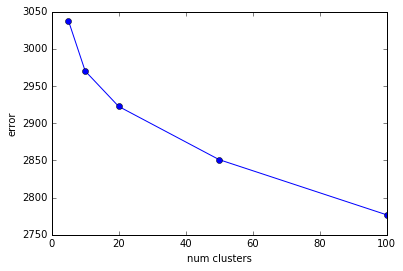

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

scores = []
num_cluster_options = [5,10,20,50,100]

for num_clusters in num_cluster_options:
    kmeans = KMeans(num_clusters, n_init=10, max_iter=10)
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('k=%d score=%g' % (num_clusters, score))
    
plt.figure()
plt.plot(num_cluster_options, scores, 'bo-')
plt.xlabel('num clusters')
plt.ylabel('error')
plt.show()

** How does error vary by initalization? **

score=2931.16
score=2938.12
score=2935.65
score=2930.09
score=2939.74
score=2930.83
score=2933.05
score=2921.78
score=2930.89
score=2934.03


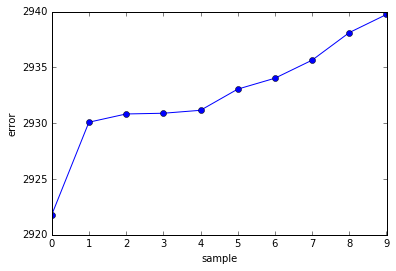

In [88]:
scores = []
for i in range(10):
    kmeans = KMeans(20, n_init=1, max_iter=100, init='random')
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('score=%g' % (score))
     
    
plt.figure()
plt.plot(range(10), sorted(scores), 'bo-')
plt.xlabel('sample')
plt.ylabel('error')
plt.show()